In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math
import pickle

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,8)

# Estadísticos
# ------------------------------------------------------------------------------

from scipy import stats
import researchpy as rp
from scipy.stats import levene
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm


# Para la gestión de los warning
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')




### ASUNCIONES

In [2]:
df_bikes= pd.read_pickle("../data/outliers_gestion.pkl")
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

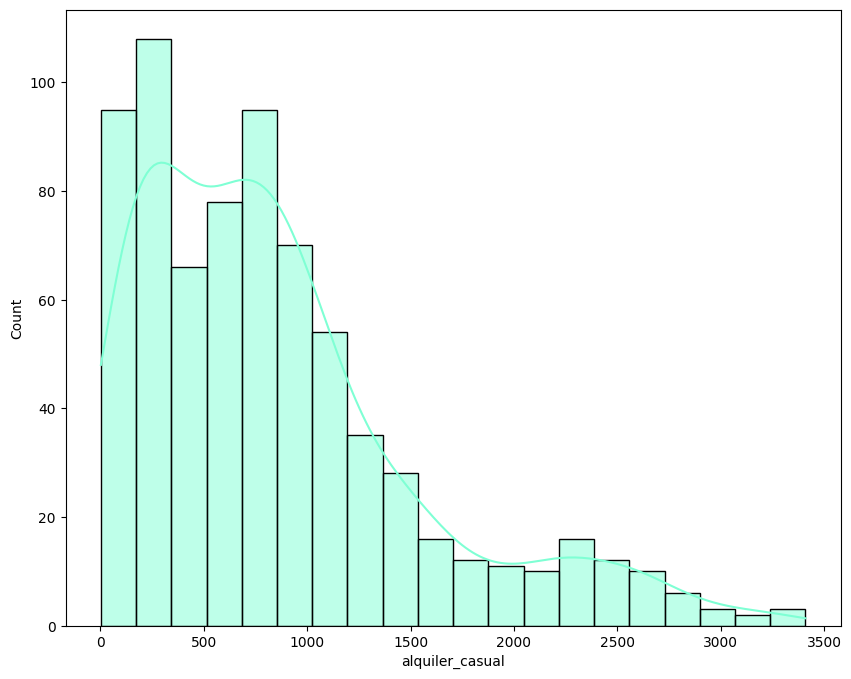

In [3]:
#Variable respuesta modelo I: 'alquiler_casual'

sns.histplot(df_bikes["alquiler_casual"], kde = True, color = "aquamarine");

In [4]:
stats.shapiro(df_bikes["alquiler_casual"])

ShapiroResult(statistic=0.885096549987793, pvalue=7.659812252880885e-23)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [5]:
#Probamos de normalizar 'alquiler_casual' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df_bikes["alquiler_casual_raiz"] = df_bikes["alquiler_casual"].apply(lambda x: math.sqrt(x))
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523


In [6]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df_bikes["alquiler_casual_raiz"])

ShapiroResult(statistic=0.9811133146286011, pvalue=4.260649788534465e-08)

In [7]:
#probamos a normalizar la variable con box-cox

df_bikes['alquiler_casual_boxcox'], lambda_ajustada = stats.boxcox(df_bikes['alquiler_casual'])
df_bikes.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz,alquiler_casual_boxcox
0,2018-01-01,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405,16.397820
1,2018-01-02,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523,11.472437


In [8]:
stats.shapiro(df_bikes["alquiler_casual_boxcox"])

ShapiroResult(statistic=0.9915904402732849, pvalue=0.00036475612432695925)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

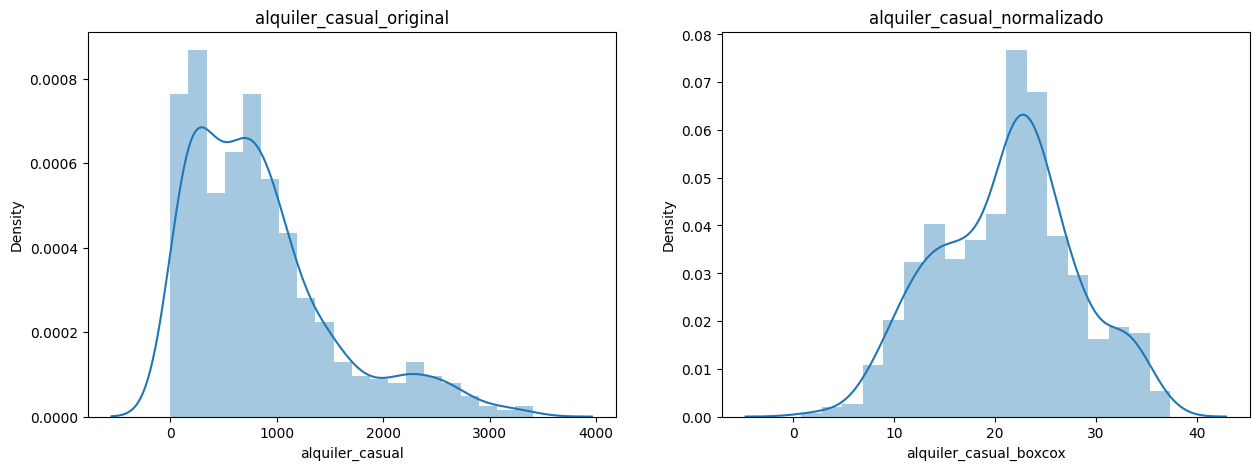

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('alquiler_casual_original')
axes[1].set_title('alquiler_casual_normalizado')
sns.distplot(df_bikes["alquiler_casual"] ,ax = axes[0])
sns.distplot(df_bikes["alquiler_casual_boxcox"], ax = axes[1]);

Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [10]:
# Nos quedamos con la columna 'alquiler_casual' ya que no hemos conseguido normalizar los datos. 
# Eliminamos la columna fecha ya que no la vamos a usar.

df_bikes.drop(['alquiler_casual_boxcox', 'alquiler_casual_raiz', 'fecha'], axis = 1, inplace = True)
df_bikes.head()

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,Invierno,2018,enero,0,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,Invierno,2018,enero,0,martes,0,2,17.68695,69.6087,16.652113,131,670,801
2,Invierno,2018,enero,0,miercoles,1,1,9.47025,43.7273,16.636703,120,1229,1349
3,Invierno,2018,enero,0,jueves,1,1,10.60610,59.0435,10.739832,108,1454,1562
4,Invierno,2018,enero,0,viernes,1,1,11.46350,43.6957,12.522300,82,1518,1600


In [11]:
# guardamos
df_bikes.to_pickle("../data/bikes_v1.pkl")

In [12]:
# creamos un df y lo guardamos sin las varibales rspuestas para poder predecir más adelante: 

df = pd.read_pickle("../data/bikes_v1.pkl")
df.drop(['alquiler_casual', 'alquiler_registrado', 'total_alquileres'], axis = 1, inplace = True)
df.to_pickle("../data/bikes_predicciones.pkl")

In [13]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)

In [14]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [15]:
# guardamos para predicción el método de estandarización:

with open ("../data/robust_casual.pkl", "wb") as f:
    pickle.dump(robust, f)  

In [16]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento
0,-0.456399,0.856714,-0.208909
1,-0.492863,0.332554,0.687550


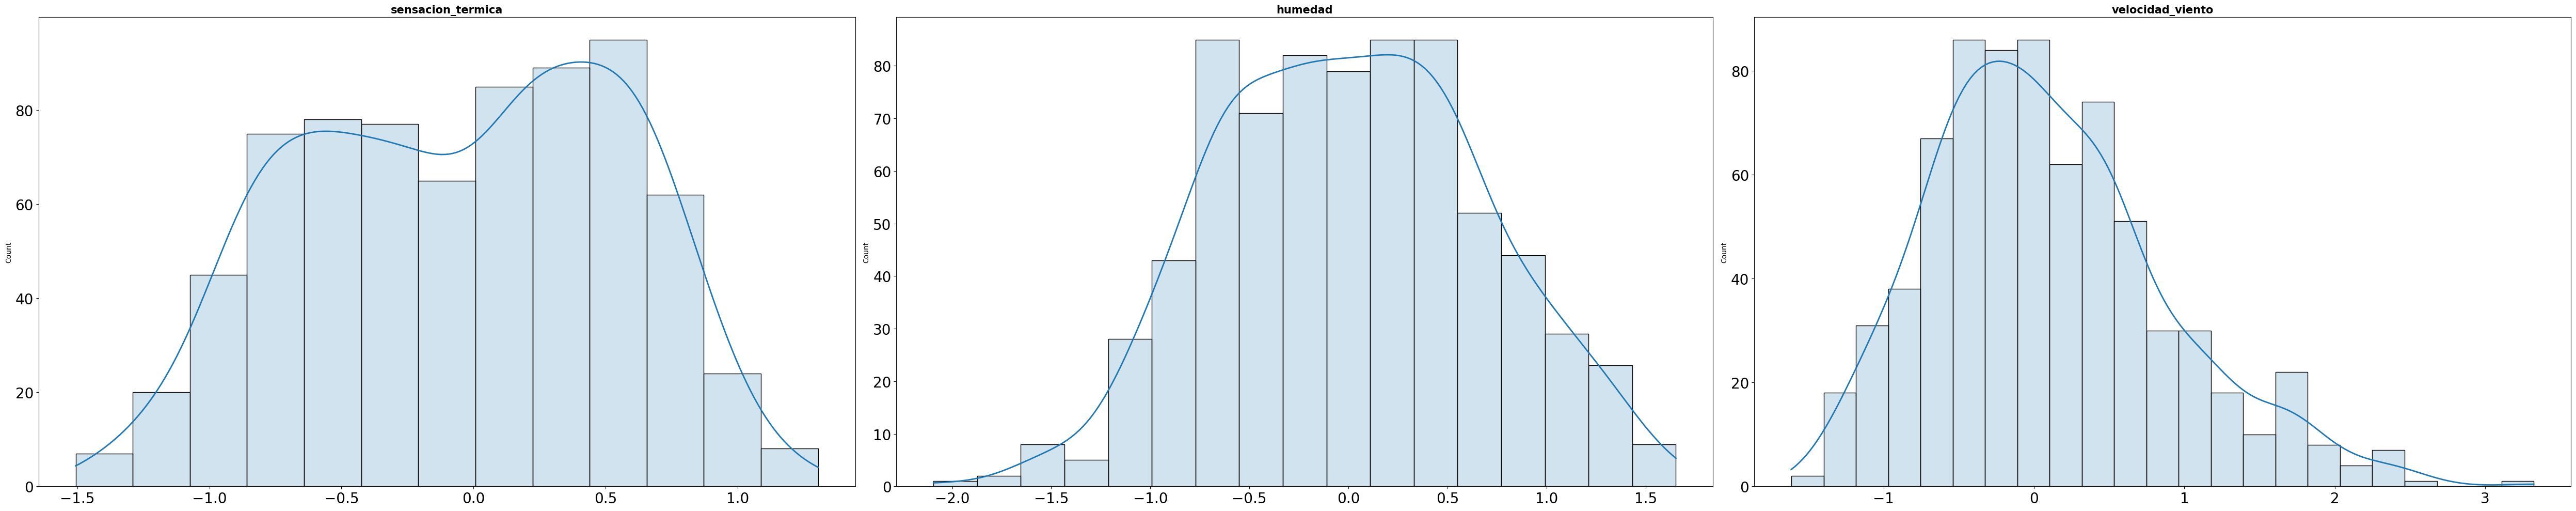

In [17]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (50, 10))
columnas_robust = numericas_robust.columns
axes = axes.flat

for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    
fig.tight_layout();

In [18]:
#Creamos un nuevo dataframe con las variables numéricas estandarizadas

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento
0,-0.456399,0.856714,-0.208909
1,-0.492863,0.332554,0.687550


Codificamos las variables categóricas

In [19]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,0,lunes,0,2
1,Invierno,2018,enero,0,martes,0,2


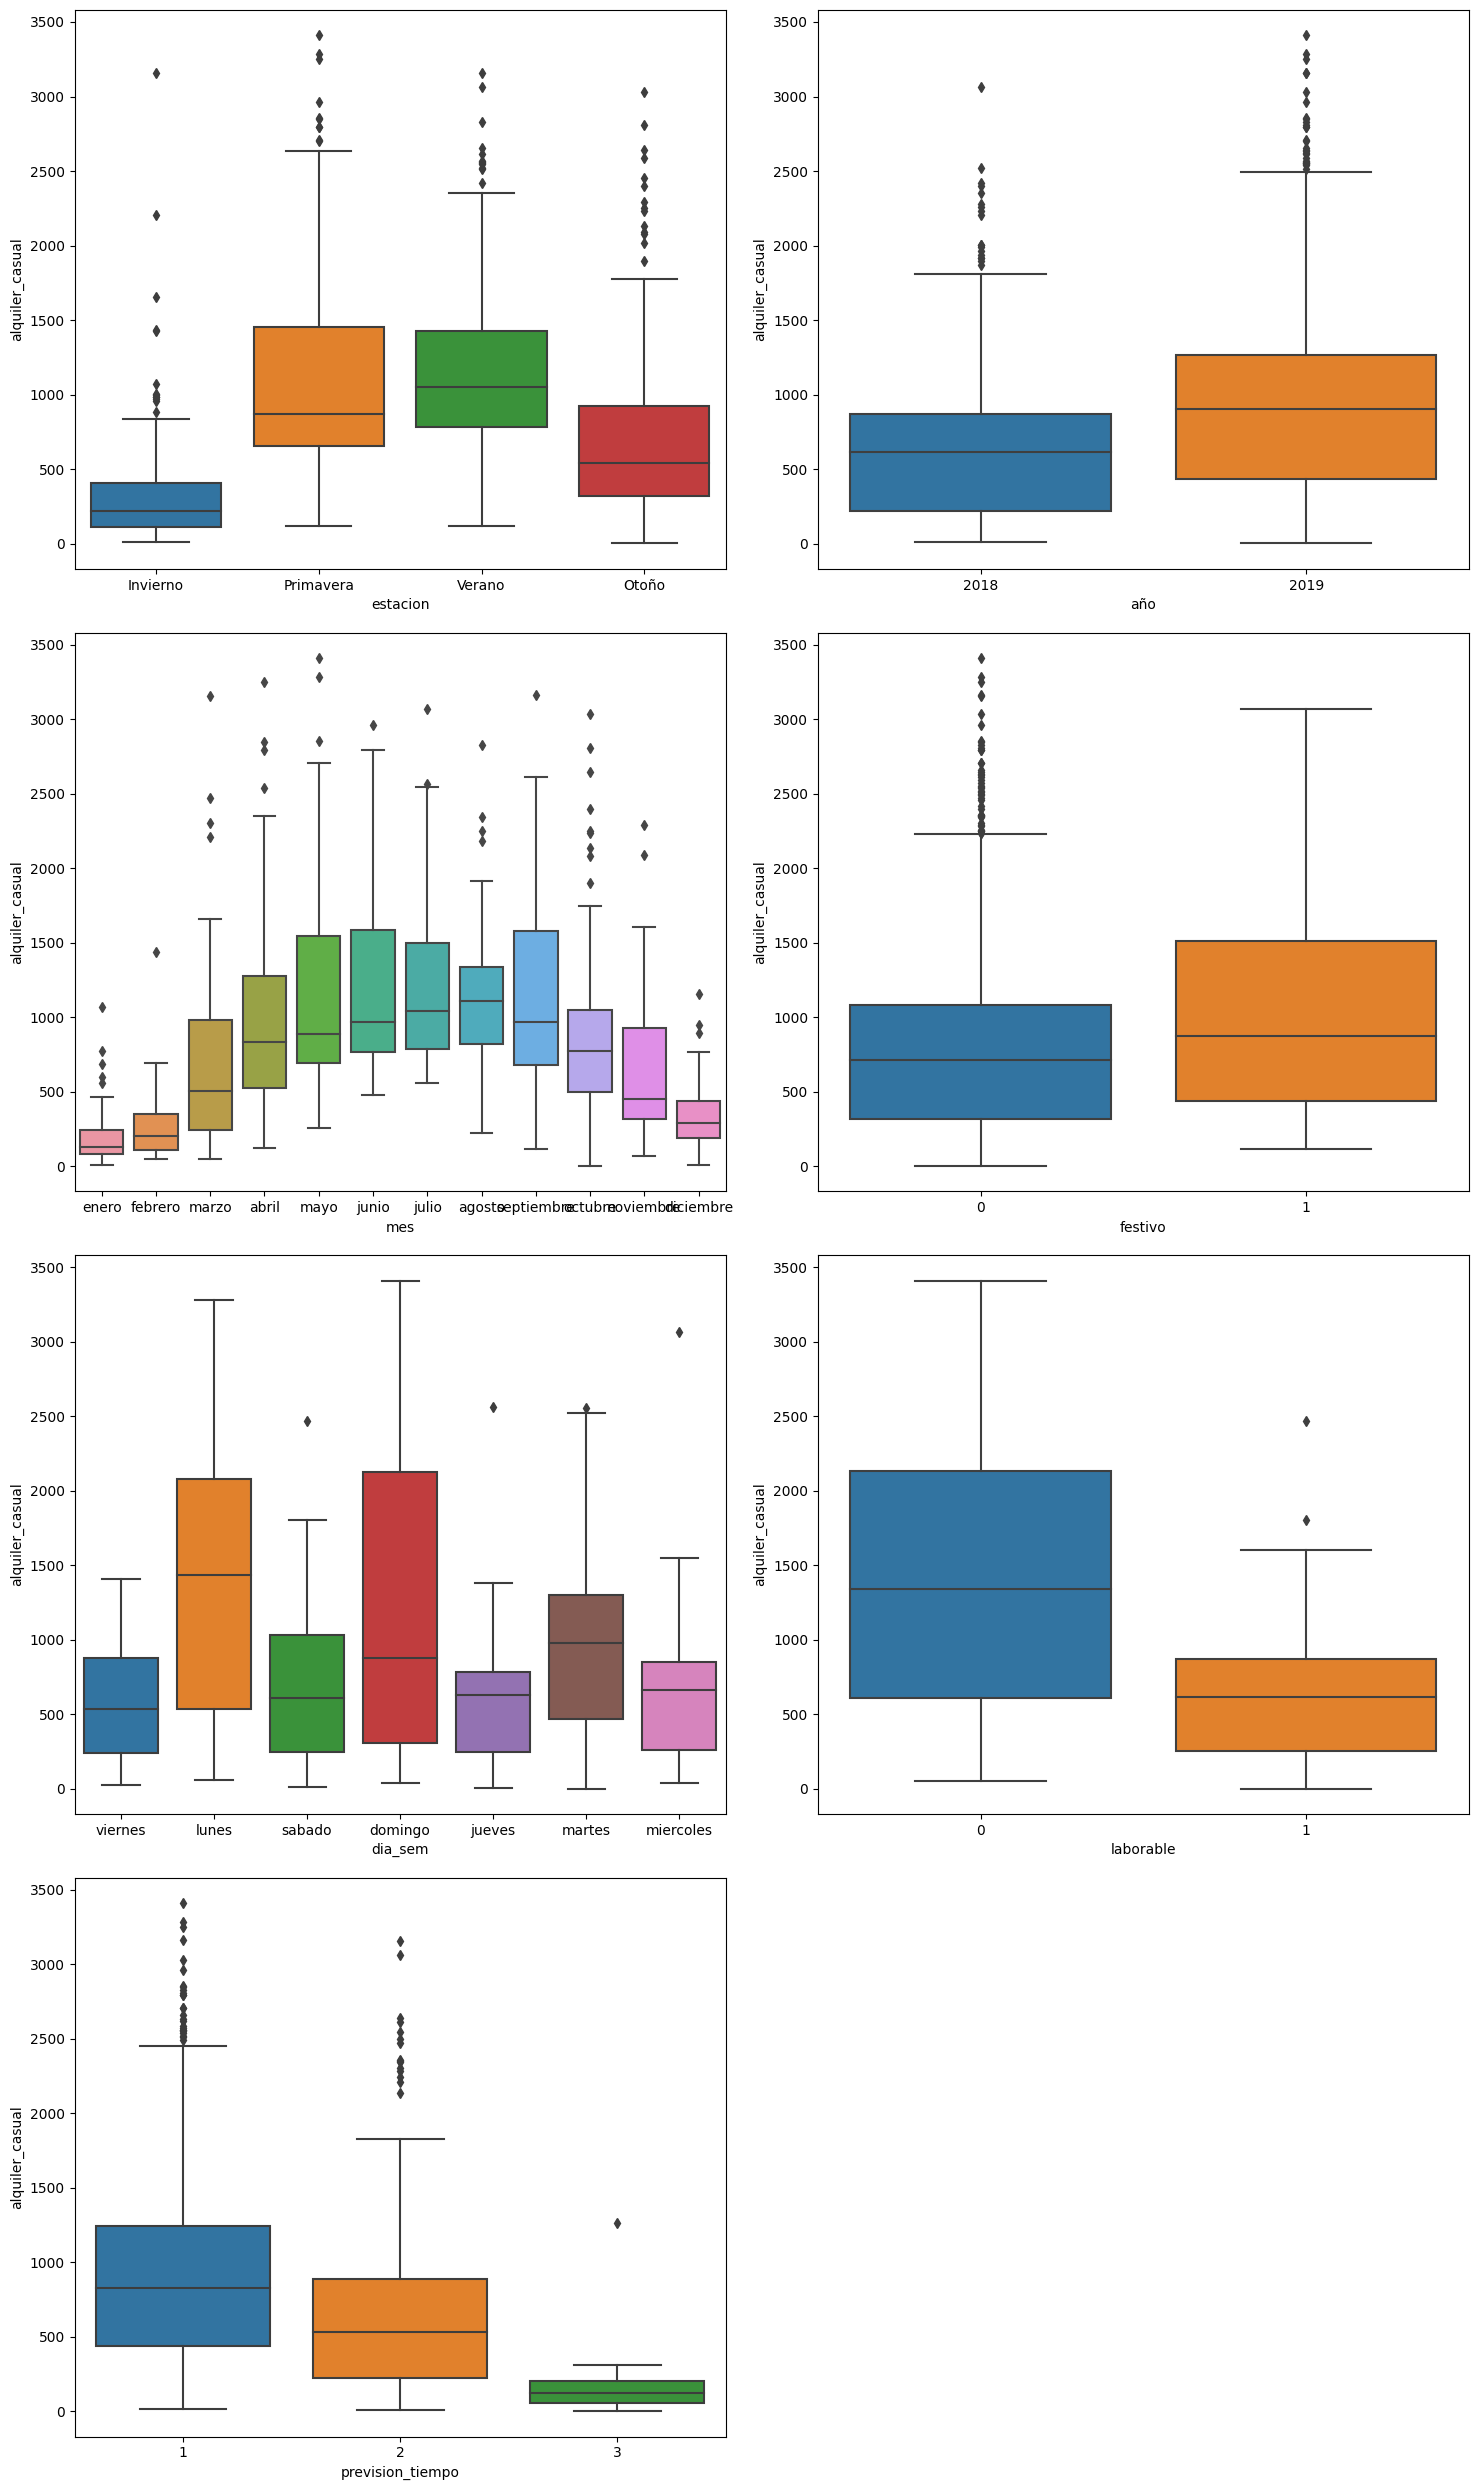

In [20]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_casual = df_cat.columns
for indice, elemento in enumerate(lista_casual):
    sns.boxplot(x = elemento, y = "alquiler_casual", data = df_bikes, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 3 puntos = 0.5 )
 
- 'estaciones': {'invierno': 0, 'otoño' = 1, 'primavera': 1.4, 'verano': 1.5}
- 'año': {'2018':0, '2019':0.5}
- 'mes': {'enero':0, 'febrero':0.5, 'diciembre': 1,
'noviembre': 1.5, 'marzo':1.5, 'octubr':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 }
- 'festivo': consideramos que no tiene orden destacable
- 'dia_sem': {'miercoles':0, 'jueves':0, 'viernes':0, 'sábado':0,
'martes':0.5, 'lunes': 0.5, 'domingo':0.5}
- 'laborable': {1:0, 0:1}
- 'prevision_tiempo': {3:0, 2:1.5, 1:2}

In [21]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [22]:
#creamos los diccionarios con el orden que queremos establecer

lista_dict = [{'Invierno': 0, 'Otoño':1, 'Primavera': 1.4, 'Verano': 1.5}, {'2018':0, '2019':0.5}, {'enero':0, 'febrero':0.5, 'diciembre': 1,
                'noviembre': 1.5, 'marzo':1.5, 'octubre':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 },
                {'miercoles':0, 'jueves':0, 'viernes':0, 'sabado':0, 'martes':0.5, 'lunes': 0.5, 'domingo':0.5}, {1:0, 0:1}, {3:0, 2:1.5, 1:2}]

#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns.drop('festivo')


In [23]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,0.0,0.0,0.0,0.5,1,1.5
1,0.0,0.0,0.0,0.5,1,1.5


In [24]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  1.4 1.5 1. ]
-------------------------
[0.0, 0.5]
Categories (2, float64): [0.0, 0.5]
-------------------------
[0.  0.5 1.5 2.  2.5 2.7 1. ]
-------------------------
[0.5 0. ]
-------------------------
[1, 0]
Categories (2, int64): [1, 0]
-------------------------
[1.5, 2.0, 0.0]
Categories (3, float64): [2.0, 1.5, 0.0]
-------------------------


In [25]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc.head()

,sensacion_termica,humedad,velocidad_viento,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,0.0,0.0,0.0,0.5,1,1.5
1,-0.492863,0.332554,0.687550,0.0,0.0,0.0,0.5,1,1.5
2,-1.098990,-0.903573,0.685210,0.0,0.0,0.0,0.0,0,2.0
3,-1.015201,-0.172053,-0.210435,0.0,0.0,0.0,0.0,0,2.0
4,-0.951952,-0.905082,0.060294,0.0,0.0,0.0,0.0,0,2.0


In [26]:
df_estenc["festivo"] = df["festivo"]
df_estenc

,sensacion_termica,humedad,velocidad_viento,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map,festivo
0,-0.456399,0.856714,-0.208909,0.0,0.0,0.0,0.5,1,1.5,0
1,-0.492863,0.332554,0.687550,0.0,0.0,0.0,0.5,1,1.5,0
2,-1.098990,-0.903573,0.685210,0.0,0.0,0.0,0.0,0,2.0,0
3,-1.015201,-0.172053,-0.210435,0.0,0.0,0.0,0.0,0,2.0,0
4,-0.951952,-0.905082,0.060294,0.0,0.0,0.0,0.0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...
725,-0.961645,0.126369,1.721399,0.0,0.5,1.0,0.0,0,1.5,0
726,-0.856880,-0.174130,-0.259536,0.0,0.5,1.0,0.0,0,1.5,0
727,-0.903524,0.603981,-0.575896,0.0,0.5,1.0,0.5,1,1.5,0
728,-0.942990,-0.683584,1.727718,0.0,0.5,1.0,0.5,1,2.0,0


In [27]:
#guardamos el dataframe

df_estenc.to_csv('../data/df_estand_encod.csv')

Decision Tree:

In [28]:
# dividimos en dos dataframes: x(predictoras) e y (variable respuesta)
# creamos los 4 grupos (train-test)
 
x= df_estenc
y = df_bikes["alquiler_casual"]

x_train_cas, x_test_cas, y_train_cas, y_test_cas = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [29]:
# instanciamos el método y lo ajustamos:

arbol_casual = DecisionTreeRegressor(random_state =0)
arbol_casual.fit(x_train_cas, y_train_cas)

DecisionTreeRegressor(random_state=0)

In [30]:
# imprimimos:

fig = plt.figure(figsize = (40, 20))
tree.plot_tree(arbol_casual, feature_names = list(x_train_cas.columns), filled = True);

In [ ]:
# calculamos la profundidad y la raíz cuadrada de las variables:

print(arbol_casual.tree_.max_depth)
print("___________")
max_features = np.sqrt(len(x_train_cas.columns))
max_features

21
___________


3.1622776601683795

In [ ]:
y_pred_test_casual = arbol_casual.predict(x_test_cas)
y_pred_train_casual = arbol_casual.predict(x_train_cas)

In [ ]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    """con esta función calculamos las métricas del árbol

    Args:
        y_test: datos test
        y_train: datos para entrenar
        y_test_pred: datos predichos predictoras (test)
        y_train_pred: datos predichos predictoras (entrenamiento)
        tipo_modelo: nombre que le queremos dar a nuestro modelo

    Returns:
        df: dataframe con las métricas
    """
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [ ]:
arbol_casual_resultado = metricas(y_test_cas, y_train_cas, y_pred_test_casual, y_pred_train_casual, "DT Casual I")
arbol_casual_resultado

,MAE,MSE,RMSE,R2,set,modelo
0,264.842466,178388.349315,422.36045,0.628686,test,DT Casual I
1,0.000000,0.000000,0.00000,1.000000,train,DT Casual I


In [ ]:
param_casual = {"max_depth": [6,8,10], # tenemos overfitting reducimos la profundidad del modelo, la nuestra anterior era de 18. 
        "max_features": [1,2,3,4],# ponemos como límite el 4 ya que el resultado de la raiz cuadrada es 3.3
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50, 100]}

In [ ]:
gs_casual = GridSearchCV(
            estimator=DecisionTreeRegressor(), # tipo de modelo que queremos hacer
            param_grid= param_casual, # hiperparámetros nuevos
            cv=10, # crossvalidation 
            verbose= 0,
            return_train_score = True, # para que nos devuelva el valor de las métricas de set de datos de entrenamiento
            scoring="neg_mean_squared_error") # la métrica que queremos que nos devuelva

gs_casual.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [6, 8, 10], 'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
mejor_modelo_casual_2 = gs_casual.best_estimator_
mejor_modelo_casual_2

DecisionTreeRegressor(max_depth=10, max_features=4, min_samples_leaf=10,
                      min_samples_split=10)

In [ ]:
y_pred_test_casual_2 = mejor_modelo_casual_2.predict(x_test_cas)
y_pred_train_casual_2 = mejor_modelo_casual_2.predict(x_train_cas)

In [ ]:
arbol_casual_resultado_2 = metricas(y_test_cas, y_train_cas, y_pred_test_casual_2, y_pred_train_casual_2, "DT Casual II")
arbol_casual_resultado_2

,MAE,MSE,RMSE,R2,set,modelo
0,228.034884,121252.086496,348.212703,0.747614,test,DT Casual II
1,204.107188,99169.637335,314.912110,0.787966,train,DT Casual II


In [ ]:
param_casual = {"max_depth": [4,5],
        "max_features": [2,3],
        "min_samples_split": [15,20,25],
        "min_samples_leaf": [15,20,25]}

In [ ]:
gs_casual_3 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_casual, 
            cv=10, 
            verbose= 0,
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_casual_3.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5], 'max_features': [2, 3],
                         'min_samples_leaf': [15, 20, 25],
                         'min_samples_split': [15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
mejor_modelo_casual_3 = gs_casual_3.best_estimator_
mejor_modelo_casual_3

DecisionTreeRegressor(max_depth=5, max_features=3, min_samples_leaf=20,
                      min_samples_split=15)

In [ ]:
y_pred_test_casual_3 = mejor_modelo_casual_3.predict(x_test_cas)
y_pred_train_casual_3 = mejor_modelo_casual_3.predict(x_train_cas)

In [ ]:
arbol_casual_resultado_3 = metricas(y_test_cas, y_train_cas, y_pred_test_casual_3, y_pred_train_casual_3, "DT Casual III")
arbol_casual_resultado_3

,MAE,MSE,RMSE,R2,set,modelo
0,265.497684,154775.410347,393.415061,0.677836,test,DT Casual III
1,269.674252,156806.523055,395.988034,0.664733,train,DT Casual III


In [ ]:
dt_resultados_casual = pd.concat([arbol_casual_resultado, arbol_casual_resultado_2, arbol_casual_resultado_3], axis = 0)
dt_resultados_casual

,MAE,MSE,RMSE,R2,set,modelo
0,264.842466,178388.349315,422.360450,0.628686,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,228.034884,121252.086496,348.212703,0.747614,test,DT Casual II
1,204.107188,99169.637335,314.912110,0.787966,train,DT Casual II
0,265.497684,154775.410347,393.415061,0.677836,test,DT Casual III
1,269.674252,156806.523055,395.988034,0.664733,train,DT Casual III


Creamos un Random Forest:

Como ya tenemos creadas las variables, vamos directamente a crear el bosque

In [ ]:
param_rf_casual = {"max_depth": [11, 12],
        "max_features": [7, 8],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 

gs_rf_casual.fit(x_train_cas, y_train_cas)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [11, 12], 'max_features': [7, 8],
                         'min_samples_leaf': [56, 57],
                         'min_samples_split': [11, 12], 'n_estimators': [100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=11, max_features=8, min_samples_leaf=56,
                      min_samples_split=11)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:02<?, ?it/s]


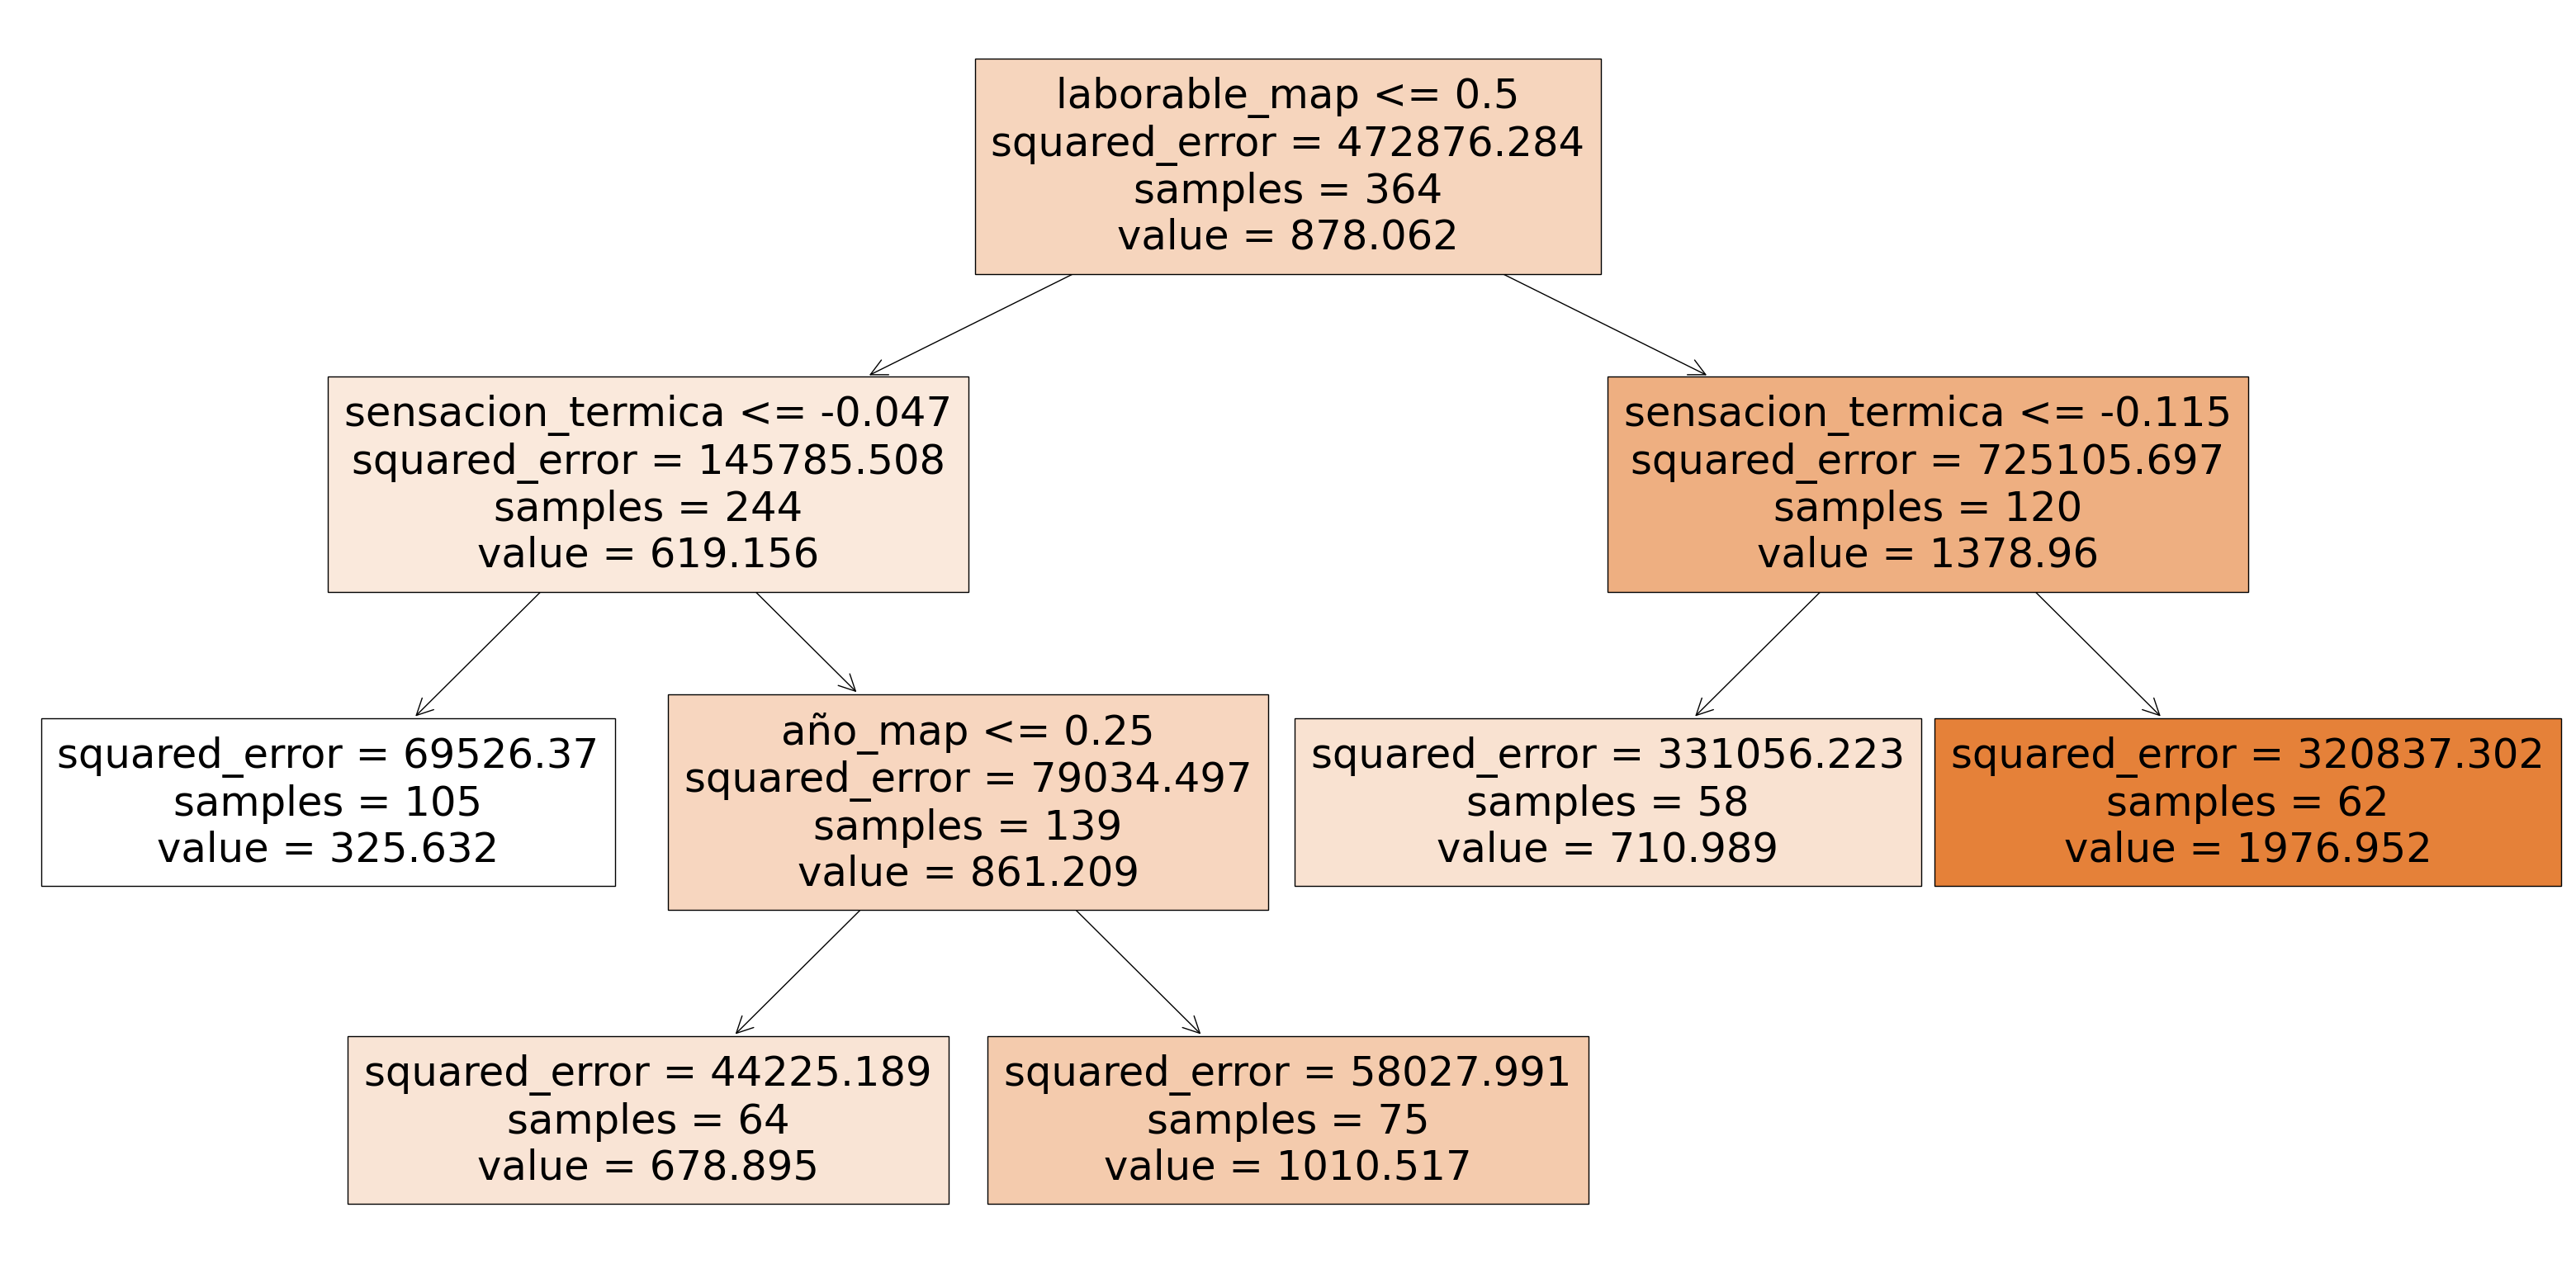

In [ ]:
for arbol in tqdm(bosque_casual):
    fig = plt.figure(figsize=(40, 20))
    tree.plot_tree(arbol, feature_names= list(x_train_cas.columns), filled = True)
    plt.savefig("../graficas/random_forest_casual.png");
    break

In [ ]:
y_pred_test_rf = bosque_casual.predict(x_test_cas)
y_pred_train_rf = bosque_casual.predict(x_train_cas)

results_forest_casual = metricas(y_test_cas, y_train_cas, y_pred_test_rf, y_pred_train_rf, "RF Casual I")
results_forest_casual

,MAE,MSE,RMSE,R2,set,modelo
0,257.351853,136374.068486,369.288598,0.716138,test,RF Casual I
1,253.445359,136917.190592,370.023230,0.707258,train,RF Casual I


In [ ]:
param_rf_casual = {"max_depth": [25,30,35,],
        "max_features": [3,4,5],
        "min_samples_split": [11, 12],
        "min_samples_leaf": [56, 57],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 



gs_rf_casual.fit(x_train_cas, y_train_cas)
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=30, max_features=5, min_samples_leaf=56,
                      min_samples_split=12)

In [ ]:
y_pred_test_rf_2 = bosque_casual.predict(x_test_cas)
y_pred_train_rf_2 = bosque_casual.predict(x_train_cas)

results_forest_casual_2 = metricas(y_test_cas, y_train_cas, y_pred_test_rf_2, y_pred_train_rf_2, "RF Casual II")
results_forest_casual_2

,MAE,MSE,RMSE,R2,set,modelo
0,263.369279,147032.255997,383.447853,0.693953,test,RF Casual II
1,270.075947,153873.802832,392.267514,0.671003,train,RF Casual II


In [ ]:
param_rf_casual = {"max_depth": [40,50],
        "max_features": [3,4,5],
        "min_samples_split": [15, 20],
        "min_samples_leaf": [60, 100],
        "n_estimators": [100]}

gs_rf_casual = GridSearchCV(
            estimator=RandomForestRegressor(n_estimators=100), 
            param_grid= param_rf_casual,
            cv=10,
            verbose=0, 
            return_train_score = True,
            scoring="neg_mean_squared_error") 



gs_rf_casual.fit(x_train_cas, y_train_cas)
bosque_casual = gs_rf_casual.best_estimator_
bosque_casual

RandomForestRegressor(max_depth=50, max_features=5, min_samples_leaf=60,
                      min_samples_split=15)

In [ ]:
y_pred_test_rf_3 = bosque_casual.predict(x_test_cas)
y_pred_train_rf_3 = bosque_casual.predict(x_train_cas)

results_forest_casual_3 = metricas(y_test_cas, y_train_cas, y_pred_test_rf_3, y_pred_train_rf_3, "RF Casual III")
results_forest_casual_3

,MAE,MSE,RMSE,R2,set,modelo
0,272.709219,152094.434829,389.992865,0.683416,test,RF Casual III
1,281.514923,163855.228904,404.790352,0.649662,train,RF Casual III


In [ ]:
rf_resultados_casual = pd.concat([results_forest_casual, results_forest_casual_2, results_forest_casual_3], axis = 0)
rf_resultados_casual

,MAE,MSE,RMSE,R2,set,modelo
0,257.351853,136374.068486,369.288598,0.716138,test,RF Casual I
1,253.445359,136917.190592,370.023230,0.707258,train,RF Casual I
0,263.369279,147032.255997,383.447853,0.693953,test,RF Casual II
1,270.075947,153873.802832,392.267514,0.671003,train,RF Casual II
0,272.709219,152094.434829,389.992865,0.683416,test,RF Casual III
1,281.514923,163855.228904,404.790352,0.649662,train,RF Casual III


In [ ]:
resultados_alquiler_casual = pd.concat([dt_resultados_casual,rf_resultados_casual], axis= 0)
resultados_alquiler_casual.to_csv("../data/resultados_alquiler_casual.csv")

In [ ]:
resultados_alquiler_casual

,MAE,MSE,RMSE,R2,set,modelo
0,264.842466,178388.349315,422.360450,0.628686,test,DT Casual I
1,0.000000,0.000000,0.000000,1.000000,train,DT Casual I
0,228.034884,121252.086496,348.212703,0.747614,test,DT Casual II
1,204.107188,99169.637335,314.912110,0.787966,train,DT Casual II
0,265.497684,154775.410347,393.415061,0.677836,test,DT Casual III
1,269.674252,156806.523055,395.988034,0.664733,train,DT Casual III
0,257.351853,136374.068486,369.288598,0.716138,test,RF Casual I
1,253.445359,136917.190592,370.023230,0.707258,train,RF Casual I
0,263.369279,147032.255997,383.447853,0.693953,test,RF Casual II
1,270.075947,153873.802832,392.267514,0.671003,train,RF Casual II


# CONCLUSIONES:

- El primero Decission Tree queda descartado por overfitting.

- El resto de Decision Trees tienen éxito porque el R2 supera el 0.7 aunque los resultados del test son inferiores al train.

- El mejor modelo sería el DT Registrado III, ya que el test tenemos un R2 de 0.73 y el train está por debajo con 0.71. En cuanto al RMSE nos da un margen de error de 358 bicis aprox. Como no hemos gestionado outliers, nos fijamos en el MAE, puesto que la principal diferencia entre MAE y RMSE radica en cómo manejan los errores. El MAE considera los errores en términos absolutos, mientras que el RMSE considera los errores al cuadrado y toma la raíz cuadrada del promedio. La elección entre estas dos métricas depende del problema en cuestión y de si se desea penalizar más los errores grandes (utiliza RMSE) o si se desea una métrica que sea más robusta ante valores atípicos (utiliza MAE).
El MAE es una métrica que calcula el promedio de las diferencias absolutas entre las predicciones de un modelo y los valores reales.
El RMSE es otra métrica que calcula el promedio de las diferencias entre las predicciones de un modelo y los valores reales, pero en este caso, las diferencias se elevan al cuadrado antes de calcular el promedio. En este caso encontramos un margen de error de 239 bicis.

In [ ]:
# guardamos para predicciones:
import pickle

with open ("../data/bosque_casual_pred.pkl", "wb") as f:
    pickle.dump(bosque_casual, f)


Importancia de las variables:

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train_cas.columns,
                             'importancia': mejor_modelo_casual_3.feature_importances_}
                            )
# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)
# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
3,estacion_map,0.361970
7,laborable_map,0.358581
5,mes_map,0.141685
4,año_map,0.076721
1,humedad,0.043321
0,sensacion_termica,0.017722
2,velocidad_viento,0.000000
6,dia_sem_map,0.000000
8,prevision_tiempo_map,0.000000
9,festivo,0.000000


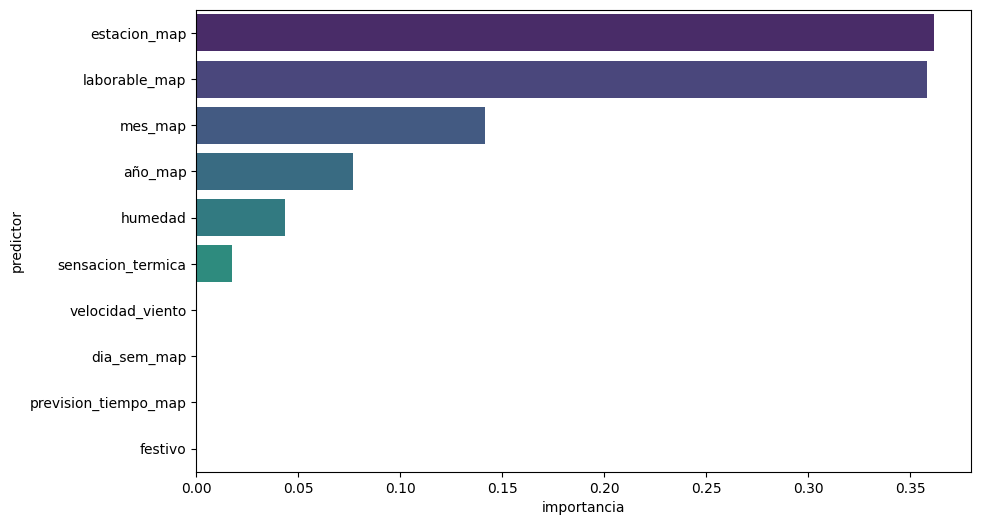

In [ ]:
# por último ploteamos los resultados para verlo de una forma más amigable.
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()